## Example 2: Regular Domain

This notebook present an example of FDSS on the horsehoe region [[1]](#ramsay2002).

The `FELSPLINE` function is a python implementation of R-package mgcv[[2]](#mgcv)'s `fs.test` function


**Reference**

<a id='ramsay2002'></a>
[1.](https://scholar.google.com/scholar_url?url=https://academic.oup.com/jrsssb/article-abstract/64/2/307/7098423&hl=zh-TW&sa=T&oi=gsb&ct=res&cd=0&d=7225501284043413252&ei=80TqZqnlDOqs6rQPw4y2sAM&scisig=AFWwaeb_5_NA2AYdJ0p5GRVgCpKa) Ramsay T (2002) Spline smoothing over difficult regions. Journal of the Royal Statistical Society: Series B (Statistical Methodology) 64(2):307–319

<a id='mgcv'></a>
[2.](https://doi.org/10.1201/9781315370279)Wood S (2017) Generalized Additive Models: An Introduction with R, 2nd edn. Chapman and
Hall/CRC


In [1]:
import torch
from fdss import FDSS, gen_grid, gen_mask
from utils import gen_fs_data, FELSPLINE
import matplotlib.pyplot as plt
from matplotlib import  colors

# device = "cuda:0" if torch.cuda.is_available() else "cpu"
device = "cpu"
fs  = FELSPLINE()

from rpy2.robjects.packages import importr
mgcv = importr('mgcv')

In [2]:
N, sde = 1e6, .1
r = .02

X, y, yt = gen_fs_data(N, sde, engine = 'p')
print("Data shape: ", X.shape, y.shape, yt.shape)

X_grid = gen_grid([-1,4], [-1,1], r=r)
print("Grid shape: ", X_grid.shape)


mask = gen_mask(X_grid, mgcv.fs_boundary())
print("Mask shape: ", mask.shape)

Data shape:  torch.Size([1000000, 2]) torch.Size([1000000]) torch.Size([1000000])
Grid shape:  torch.Size([251, 101, 2])
Mask shape:  torch.Size([251, 101])


Text(0.5, 1.0, 'mask')

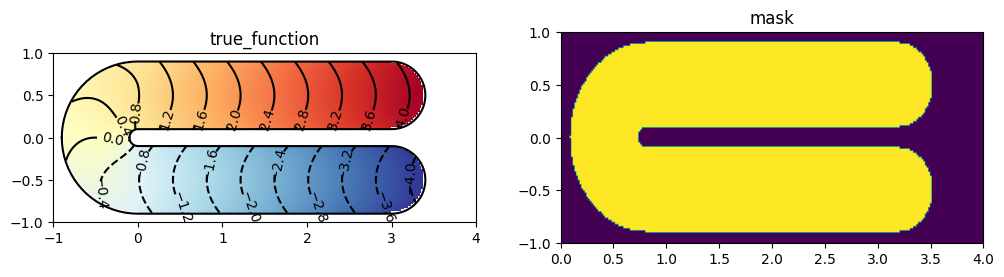

In [3]:
plt.figure(figsize=(12,4))

ax = plt.subplot(1, 2, 1)
xg, zg = X_grid.unbind(-1)
trug, _ = fs.test(xg, zg)
fs.plot(xg, zg, trug,pred=True)
plt.title("true_function")

ax = plt.subplot(1, 2, 2)
values= mask.unique()
img = plt.imshow(mask.flip(dims=(1,)).T, extent=[0,4]+[-1,1])
plt.title("mask")

In [4]:
model = FDSS(X_grid, mask=mask, device=device)
model.fit(X, y, print_every=True)
print('sp = ', model.best_sp.item(), f" ( iter = {model.n_iter})")

/home/luhung/.venv/torch/lib/python3.10/site-packages/torch/autograd/__init__.py:300: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


lam = 3.41E-18, mse = 0.01025 (-inf), iter = 200
lam = 1.22E-15, mse = 0.01025 (0.000), iter = 200
lam = 4.34E-13, mse = 0.01025 (0.000), iter = 3
lam = 1.55E-10, mse = 0.01025 (0.000), iter = 79
lam = 5.52E-08, mse = 0.01025 (0.000), iter = 6
lam = 1.97E-05, mse = 0.01025 (0.000), iter = 1
lam = 7.01E-03, mse = 0.01006 (-0.000), iter = 150
lam = 2.50E+00, mse = 0.06100 (0.051), iter = 200
lam = 8.92E+02, mse = 0.06496 (0.055), iter = 200
lam = 3.18E+05, mse = 0.06498 (0.055), iter = 200
sp =  0.00701439194381237  ( iter = 148)


In [5]:
_, mse = model.transform(X, y, eval_func='mse')
print(f"mse = {mse:.2E}")

mse = 9.98E-03


In [6]:
yg, ise = model.transform(X_grid.reshape(-1,2), trug.reshape(-1))
yg = yg.reshape(model.Y_grid.shape)
print(f"ise = {ise:.2E}")

ise = 1.61E-05


Text(0.5, 1.0, 'sp = 7.01E-03, ise = 1.61E-05')

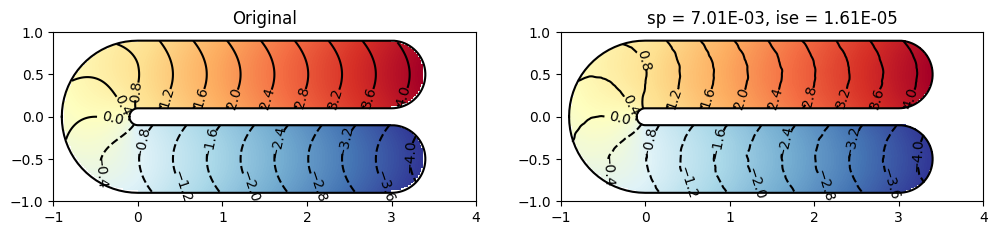

In [7]:
plt.figure(figsize=(12, 4))
level = 15

ax = plt.subplot(1, 2, 1)
fs.plot(xg,zg,trug,pred=True)
ax.set_title(f"Original")

ax = plt.subplot(1, 2, 2)
fs.plot(xg,zg, yg, pred=True)
ax.set_title(f"sp = {model.best_sp.item():.2E}, ise = {ise:.2E}")